In [1]:
from pathlib import Path
import os
import sys
import math
import pandas as pd
import numpy as np
from datetime import datetime, time

project_root = Path.cwd().parent
src_path = project_root / "src"
sys.path.append(str(src_path))
os.chdir(project_root)
sys.argv = ["notebook", "--config", "/Users/alicealbrecht/wynton_home/PSG_Pipeline/config/mros_ses-1_config.yaml"] 

from config.read_config import read_config
from pipeline_io.get_mastersheet import get_mastersheet
from pipeline_io.edf_to_h5 import edf_to_h5
from pipeline_io.read_annot import read_annot
from analysis.process_sleep_stages import process_sleep_stages
from analysis.process_signals import process_signals
from analysis.selecting_windows import selecting_windows
from features.extract_features import extract_features
from pipeline_io.save_features import save_features, save_features_wide

/opt/homebrew/Caskroom/miniconda/base/envs/env_sleep_py310/lib/python3.10/site-packages/nolds/datasets.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Check of the pipeline
This notebook allow to check that the pipeline is indeeed doing a correct processing of the PSG by focusing on one subject. The subject selected can be changed.

In [2]:
# selected_subject = "S0001111449984" # Xltek
# selected_subject = "S0001111534857" #Xltek2
# selected_subject = "S0001111206862" # events + sleep
# selected_subject = "S0001111206646" # psg_annot
selected_subject = "bi0002" # array not same size

#### Read Config

In [3]:
config, config_path = read_config()

In [4]:
config

Box({'dataset': {'name': 'mros', 'session': 1}, 'paths': {'input': '/Users/alicealbrecht/wynton_data/MrOS/mros-sof_mjhe/vs/EDF/', 'output': '/Users/alicealbrecht/Desktop/PSG_Pipeline_Outputs/', 'mastersheets': PosixPath('/Users/alicealbrecht/Desktop/PSG_Pipeline_Outputs/mastersheets'), 'h5_data': PosixPath('/Users/alicealbrecht/Desktop/PSG_Pipeline_Outputs/h5_data/mros_ses-1'), 'events': PosixPath('/Users/alicealbrecht/Desktop/PSG_Pipeline_Outputs/events/mros_ses-1'), 'extracted_features': PosixPath('/Users/alicealbrecht/Desktop/PSG_Pipeline_Outputs/extracted_features/mros_ses-1')}, 'output': {'overwrite_mastersheet': False, 'overwrite_h5': False, 'overwrite_events': False, 'overwrite_old_features': True}, 'features': {'extract_all': False, 'selected': ['hrv', 'cpc', 'hrnadir']}, 'analysis': {'rpeaks_detection_method': 'Farhad_Kenn', 'ecg_contamination_removal_method': True, 'window_size_min': 5, 'window_step_sec': 30, 'clean_rpeaks_ratio_threshold': 1, 'stage_types': ['WN'], 'stage_pu

#### Get Mastersheet and H5 file 

In [5]:
mastersheet = get_mastersheet(config)
rows = mastersheet.sort_values("sub_id").to_dict(orient="records")
rows = [row for row in rows if row["sub_id"] == selected_subject]

for row in rows:
    for key in ["annot_path", "sleep_stage_path", "edf_path"]:  # replace with relevant columns
        if key in row and not pd.isna(row[key]):
            row[key] = row[key].replace(
                "/wynton/group/andrews/data/",
                "/Users/alicealbrecht/wynton_data/"
            )

for row in rows:
    for key in ["h5_path", "events_path", "extracted_features_path"]:
        if key in row and row[key] is not None:
            row[key] = row[key].replace(
                "/wynton/group/andrews/data/",
                "/Users/alicealbrecht/Desktop/"
            )

[INFO] Loading existing mastersheet from /Users/alicealbrecht/Desktop/PSG_Pipeline_Outputs/mastersheets/mros_ses-1_mastersheet.csv


In [6]:
rows

[{'sub_id': 'bi0002',
  'dataset': 'mros',
  'site': 'bi',
  'session': 1,
  'start_time': '2004-04-12 20:48:27+00:00',
  'sfreq_global': 512.0,
  'duration_samples': 17095680,
  'duration_sec': 33390.0,
  'edf_path': '/Users/alicealbrecht/wynton_data/MrOS/mros-sof_mjhe/vs/EDF/bi/bi0002.edf',
  'annot_path': '/Users/alicealbrecht/wynton_data/MrOS/mros-sof_mjhe/vs/EDF/bi/bi0002.edf.XML',
  'h5_path': '/Users/alicealbrecht/Desktop/PSG_Pipeline_Outputs/h5_data/mros_ses-1/mros_ses-1_sub-bi0002_signals.h5',
  'events_path': '/Users/alicealbrecht/Desktop/PSG_Pipeline_Outputs/events/mros_ses-1/mros_ses-1_sub-bi0002_events.csv',
  'extracted_features_path': '/Users/alicealbrecht/Desktop/PSG_Pipeline_Outputs/extracted_features/mros_ses-1/run_20251002/mros_ses-1_sub-bi0002_extracted_features.csv'}]

In [7]:
# edf_to_h5(config, rows)

### Annotations file 

In [7]:
# Temporary directory for one subject
row = rows[0]
sub_key = f"{config.dataset.name.lower()}_ses-{config.dataset.session}_sub-{row['sub_id']}"
project_root = Path("/Users/alicealbrecht/wynton_home/PSG_Pipeline")
tmp_dir = project_root / "tmp" 
tmp_dir_sub = tmp_dir / f"{row['sub_id']}"
print(tmp_dir_sub)
tmp_dir_sub.mkdir(parents=True, exist_ok=True)

/Users/alicealbrecht/wynton_home/PSG_Pipeline/tmp/bi0002


In [8]:

def datetime_to_sec(t_input):
    """
    Convert time-like input to seconds since midnight (float, including milliseconds).
    """

    if t_input is None or (isinstance(t_input, float) and np.isnan(t_input)):
        return np.nan

    # --- Handle datetime or time objects ---
    if isinstance(t_input, datetime):
        t_obj = t_input.time()
    elif isinstance(t_input, time):
        t_obj = t_input
    else:
        # Convert to string and strip
        t_str = str(t_input).strip()
        # Remove timezone suffix if present (e.g. +00:00)
        t_str = t_str.split('+')[0].split('Z')[0]

        t_obj = None
        # Try multiple formats
        for fmt in [
            "%Y-%m-%d %H:%M:%S.%f",
            "%Y-%m-%d %H:%M:%S",
            "%I:%M:%S %p",
            "%H:%M:%S.%f",
            "%H:%M:%S"
        ]:
            try:
                t_obj = datetime.strptime(t_str, fmt).time()
                break
            except ValueError:
                continue

        if t_obj is None:
            print(f"[WARNING] Could not parse time: {t_input}")
            return np.nan

    # --- Compute seconds including fractional part ---
    t_sec = (
        t_obj.hour * 3600 +
        t_obj.minute * 60 +
        t_obj.second +
        t_obj.microsecond / 1e6
    )

    return t_sec



def read_annot_MGB(row):
    sub_id = row["sub_id"]
    session = row["session"]
    psg_id = f"sub-{sub_id}_ses-{session}" 
    duration_sec = row["duration_sec"]
    annot_path = row["annot_path"]
    sleep_stage_path = row["sleep_stage_path"]

    ### ANNOTATION FILE 
    if pd.isna(annot_path): # Creating empty 
        print(f"[WARNING] {psg_id}: No Annot Stage Path found.") # 1 time
        df_events = pd.DataFrame(columns=["onset", "duration", "event_type"])
        full_sleep_stages = []
        epoch_length_sec = 30

    else: # Read the slepe stage from the specific file 
        #print("Reading:", annot_path)
        df_annot = pd.read_csv(annot_path) 

        # Most classic MGB case one file with both events and sleep stages
        required_cols_psg = {"time", "duration", "event"}
        if (("psg_annot" in annot_path.lower() or "xltek" in annot_path.lower())
            and required_cols_psg.issubset(df_annot.columns)):

            df_events = df_annot[list(required_cols_psg)].copy()
            df_events = df_events.rename(columns={
                "event": "event_type"
            })

            # Convert 'duration' → numeric (replace unvalid with 0.0)
            df_events['duration'] = pd.to_numeric(df_events['duration'], errors='coerce').fillna(0.0)

            # Converting onset in sec 
            df_events['onset_sec'] = df_events['time'].apply(datetime_to_sec)
            
            # Ensure post midnight 
            continuous_sec = []
            prev_sec = 0
            for sec in df_events['onset_sec']:
                if pd.isna(sec):  # safer than np.isnan()
                    continuous_sec.append(np.nan)
                    continue
                if sec < prev_sec:  # passed midnight
                    sec += 24*3600
                continuous_sec.append(sec)
                prev_sec = sec
            df_events['onset'] = continuous_sec

            # --- Handle time issues ---
            # We want to match the start_time of the EDF file
            print(f"EDF start_time: {row['start_time']}")
            edf_start_sec = datetime_to_sec(row["start_time"]) 


            #### FIRST EVENT ####

            # Find the index of the first "start" event or first valid
            start_mask_event = (
                df_events["event_type"].str.lower().str.contains("start", case=False, na=False) &
                df_events["event_type"].str.lower().str.contains("rec", case=False, na=False)
            )
            if start_mask_event.any():
                first_event_idx = df_events[start_mask_event].index[0]
            else:
                first_event_idx = df_events["event_type"].first_valid_index()
            
            # Convert onset time to time object + seconds
            event_start_sec = df_events.loc[first_event_idx, "onset"]

            # Debug print 
            print(f"First sleep event {df_events.loc[first_event_idx, 'event_type']} @ {df_events.loc[first_event_idx, 'time']}")

            #### Adjuste with EDF start_time ####

            # Compute both offset: event and sleep
            offset_sec_event = int(event_start_sec - edf_start_sec)
            print("event: ", edf_start_sec, event_start_sec, offset_sec_event)

            # First adjust in function of offset_sec_event
            if abs(offset_sec_event) <= 1:
                print(f"[OK] {psg_id}: Shift of {offset_sec_event} s")
                df_events["onset"] = df_events["onset"].astype(float) - offset_sec_event
            elif offset_sec_event < -1:
                print(f"[ERROR] {psg_id}: Event start before recording...")
            else:
                print(f"[WARNING] {psg_id}: offset_event >1s ({offset_sec_event:.3f}s)")
                df_events["onset"] = df_events["onset"].astype(float) + offset_sec_event


            #### FIRST SLEEP STAGE ####              

            # Find the index of the first "start" event or first valid
            mask_sleep = df_events["event_type"].str.lower().str.startswith("sleep_stage_")
            if mask_sleep.any():
                first_sleep_idx = df_events[mask_sleep].index[0]
            else:
                print(f"[ERROR] {psg_id}: mask_sleep is empty no sleep stages found.")

            # Convert onset time to time object + seconds
            sleep_start_sec =df_events.loc[first_sleep_idx, "onset"] 

            # Debug print 
            print(f"First sleep event {df_events.loc[first_sleep_idx, 'event_type']} @ {df_events.loc[first_sleep_idx, 'time']}")

            # Compute offset
            offset_sec_sleep = int(sleep_start_sec - edf_start_sec)
            print("sleep: ", edf_start_sec, sleep_start_sec, offset_sec_sleep)

            # Now remove start time to have a first onset of 0 
            df_events['onset'] = df_events['onset'] - edf_start_sec
            if df_events.loc[0,'onset'] < 0:
                print(f"[ERROR] {psg_id}:First event before start recording...")

            # Divide events and sleep stages
            df_sleep = df_events[mask_sleep].copy()
            df_events = df_events[~mask_sleep].copy()

            # Drop unused col 
            df_events.drop(columns=["time", "onset_sec"], inplace=True)
            
            # # Then print warning if first epoch not matching 30s
            n_missing_epoch = 0
            if offset_sec_sleep < 0:
                print(f"[WARNING] {psg_id}: sleep stages start before recording...")
            elif not (abs(offset_sec_sleep % 30) <= 1 or abs((30 - offset_sec_sleep % 30)) <= 1):
                print(f"[WARNING] {psg_id}: first sleep stage is not aligned with 30s epoch size")
            else:
                n_missing_epoch = int(round(offset_sec_sleep / 30))
                if n_missing_epoch != 0:
                    print(f"[INFO] {psg_id}: {n_missing_epoch} missing epochs at the start")

            # Deduce full_sleep_stage now
            raw_stages = df_sleep['event_type'].str.lower().str.split("sleep_stage_").str[-1]
            raw_stages = pd.Series(["W"] * n_missing_epoch + raw_stages.tolist())

            stage_dict = {"W": 0, "WAKE": 0, 
                    "N1": 1, 
                    "N2": 2, 
                    "N3": 3, "N4": 3, 
                    "R": 4, "REM": 4}
            full_sleep_stages = [stage_dict.get(str(s).upper(), np.nan) for s in raw_stages]
             
            # Create a df_stages
            epoch_length_sec = 30
            n_epochs = int(duration_sec / epoch_length_sec)

            # Warnings and adjustments for length mismatches
            if len(full_sleep_stages) > 0: 
                if len(full_sleep_stages) != n_epochs:
                    if len(full_sleep_stages) > n_epochs:
                        to_trim = full_sleep_stages[n_epochs:]
                        
                        if any(not (np.isnan(x) or x == 0) for x in to_trim):
                            print(f"[WARNING] {psg_id}: Trimming extra sleep_stages: {to_trim}")
                        full_sleep_stages = full_sleep_stages[:n_epochs]
                    else:
                        n_epoch_to_add = n_epochs - len(full_sleep_stages)
                        full_sleep_stages = full_sleep_stages + [0] * n_epoch_to_add
                        print(f"[WARNING] {psg_id}: Stages too short so added {n_epoch_to_add} epochs to reach {n_epochs} epochs.")
                
            # Create DataFrame for sleep stages
            df_stages = pd.DataFrame({
                'onset': np.arange(0, n_epochs * 30, 30),
                'duration': np.full(n_epochs, 30),
                'sleep_stage': full_sleep_stages 
            })

            # -------- CONCAT SLEEP EVENTS ----------
            df_stages = df_stages.assign(event_type=np.nan)
            df_events = df_events.assign(sleep_stage=np.nan)
            df_events = (
                pd.concat([df_stages, df_events], ignore_index=True)
                .sort_values('onset', kind='mergesort')
                .reset_index(drop=True)
            )
        else:
            df_events = pd.DataFrame(columns=["onset", "duration", "event_type"])
            full_sleep_stages = []
            epoch_length_sec = 30
            print(f"[OTHER] {psg_id}: NEED XLTEK OR PSG ANNOT + 3 CORRECT COLS", flush=True)

    return full_sleep_stages, df_events, epoch_length_sec

In [ ]:
full_sleep_stages, df_events, epoch_length_sec = read_annot_MGB(row)

EDF start_time: 2017-01-03 20:48:34+00:00
First sleep event Start Recording @ 20:48:34
event:  74914.0 74914.0 0
[OK] sub-S0001111190905_ses-3: Shift of 0 s
First sleep event Sleep_stage_? @ 20:48:34
sleep:  74914.0 74914.0 0
[WARNING] sub-S0001111190905_ses-3: Stages too short so added 9 epochs to reach 1085 epochs.


In [8]:
full_sleep_stages, df_events = read_annot(
        row,
        dataset_name=config.dataset.name)

In [9]:
from collections import Counter

counts = Counter(full_sleep_stages)
print(counts)

Counter({0: 7941120, 2: 7879680, 3: 675840, 1: 599040})


In [10]:
# Check if full_sleep_stages does NOT contain any 1, 2, 3, or 4
if not any(s in [1, 2, 3, 4] for s in full_sleep_stages if not math.isnan(s)):
    print(f"[ERROR] Sub {row['sub_id']}: full_sleep_stages contains no valid stages!", flush=True)

In [11]:
sleep_stages, sleep_onset_time = process_sleep_stages(
        full_sleep_stages, 
        sfreq_global = row["sfreq_global"],
        start_time = row["start_time"],
        verbose = config.run.verbose)

Start time: 2004-04-12 20:48:27+00:00
Sleep Onset seconds: 10020.0
Sleep Onset time: 2004-04-12 23:35:27+00:00


### Process Signal

In [12]:
processed_signals = process_signals(
        config, 
        row,
        full_sleep_stages, 
        tmp_dir_sub)

print("Length ECG singal (only night)",len(processed_signals["ECG"]["signal"]))
print("First clean_rpeaks",processed_signals["ECG"]["clean_rpeaks"][0])
print("Last clean_rpeaks",processed_signals["ECG"]["clean_rpeaks"][-1])

[INFO]: Processing Signal: ecg
Peak Detection for ECG with Farhad_Kenn
Option -softwareopengl does not apply on MAC.
Percentage of clean Rpeaks: 97.63842107255043 %
Length ECG singal (only night) 10106880
First clean_rpeaks 586
Last clean_rpeaks 10106269


In [13]:
processed_signals["ECG"]["clean_rpeaks"][-10:] / row["sfreq_global"]

array([19731.5625    , 19732.35742188, 19733.15625   , 19733.9609375 ,
       19734.765625  , 19735.56640625, 19736.37304688, 19737.18945312,
       19737.99804688, 19738.80664062])

In [14]:
row["sfreq_global"]

512.0

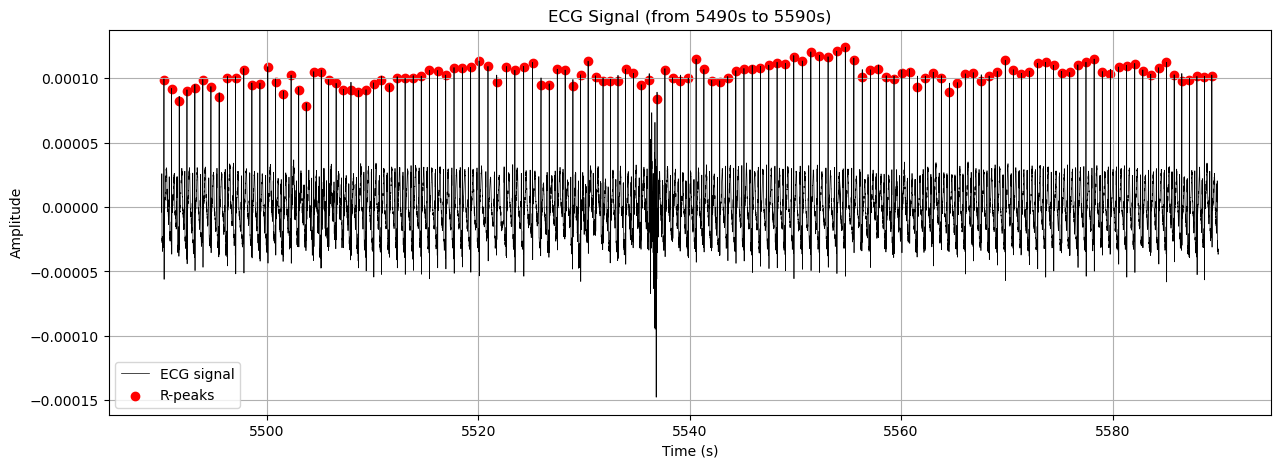

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data
signal = processed_signals["ECG"]["signal"]
sfreq = processed_signals["ECG"]["sfreq_signal"]
clean_rpeaks = processed_signals["ECG"]["clean_rpeaks"]

# Define start time (in seconds) and window (60s)
start_sec = (5550 - (60)) 
window_sec = 100

# Convert to sample indices
start_idx = int(start_sec * sfreq)
end_idx = int((start_sec + window_sec) * sfreq)

# Time axis for the signal
time_axis = np.arange(start_idx, end_idx) / sfreq

# Slice signal
segment = signal[start_idx:end_idx]

# Select R-peaks within this window
mask = (clean_rpeaks >= start_idx) & (clean_rpeaks < end_idx)
rpeaks_in_window = clean_rpeaks[mask]
rpeaks_time = rpeaks_in_window / sfreq
rpeaks_values = signal[rpeaks_in_window]

# Plot
plt.figure(figsize=(15, 5))
plt.plot(time_axis, segment, label="ECG signal", color="black", linewidth=0.5)
plt.scatter(rpeaks_time, rpeaks_values, color="red", marker="o", label="R-peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"ECG Signal (from {start_sec}s to {start_sec + window_sec}s)")
plt.legend()
plt.grid(True)
plt.show()

### Windows 

In [16]:
windows_dict = None
if config.features.extract_all or any(f in config.features.selected for f in ["hrv", "cpc"]):
    windows_dict = selecting_windows(config, row, sleep_stages, sleep_onset_time, processed_signals)

[INFO] Selecting window for signal ECG
Max sample start: 9953280
Total candidate windows: 649
Rejected window 2004-04-12 23:35:27+00:00 (0) due to low clean ratio: 0.9968489583333333
Rejected window 2004-04-13 00:05:57+00:00 (936960) due to low clean ratio: 0.9944986979166667
Rejected window 2004-04-13 00:06:27+00:00 (952320) due to low clean ratio: 0.9944986979166667
Rejected window 2004-04-13 00:06:57+00:00 (967680) due to low clean ratio: 0.9944986979166667
Rejected window 2004-04-13 00:07:27+00:00 (983040) due to low clean ratio: 0.9944986979166667
Rejected window 2004-04-13 00:07:57+00:00 (998400) due to low clean ratio: 0.9944986979166667
Rejected window 2004-04-13 00:08:27+00:00 (1013760) due to low clean ratio: 0.9944986979166667
Rejected window 2004-04-13 00:08:57+00:00 (1029120) due to low clean ratio: 0.9944986979166667
Rejected window 2004-04-13 00:09:27+00:00 (1044480) due to low clean ratio: 0.9944986979166667
Rejected window 2004-04-13 00:09:57+00:00 (1059840) due to low

In [16]:
sleep_onset_time

datetime.datetime(2004, 4, 12, 23, 35, 27, tzinfo=datetime.timezone.utc)

In [20]:
row['start_time']

'2004-04-12 20:48:27+00:00'

In [23]:
sleep_onset_time

datetime.datetime(2004, 4, 12, 23, 35, 27, tzinfo=datetime.timezone.utc)

In [32]:
## Read XML raw to check 
import xmltodict
import numpy as np
from datetime import timedelta, datetime

# convert start_time string to datetime
start_time = datetime.fromisoformat(row['start_time'])

# read XML annotation
with open(row['annot_path'], encoding='utf-8') as f:
    info_dict = xmltodict.parse(f.read())

# extract sleep stages and epoch length
sleep_stages_node = info_dict['CMPStudyConfig']['SleepStages']['SleepStage']
epoch_time = float(info_dict['CMPStudyConfig']['EpochLength'])  # seconds

print("Duration EDF:", row['duration_sec'])
print("Duration Annot:", len(sleep_stages_node) * epoch_time)

sleep_stages_node = np.array(sleep_stages_node)  # ensure it's a NumPy array
sleep_stages_to_find = ['1', '2', '3', '4', '5']  # stages considered as “sleep”
sleep_idxs = np.where(np.isin(sleep_stages_node, sleep_stages_to_find))[0]
if len(sleep_idxs) == 0:
    print("No sleep detected!")
else:
    first_idx = sleep_idxs[0]
    last_idx = sleep_idxs[-1]
    sleep_part = sleep_stages_node[first_idx : last_idx + 1]
    print(Counter(sleep_part))
    print(f"start {first_idx} - end {last_idx + 1}")
    print("Sleep part length:", len(sleep_part))
    print("Total stages:", len(sleep_stages_node))


# iterate over epochs
for i, stage in enumerate(sleep_stages_node):
    timestamp = start_time + timedelta(seconds=epoch_time * i)
    # convert stage to int if needed
    stage_int = int(stage)
    print(timestamp, stage_int)

Duration EDF: 33390.0
Duration Annot: 33390.0
Counter({'2': 513, '0': 62, '3': 44, '1': 39})
start 334 - end 992
Sleep part length: 658
Total stages: 1113
2004-04-12 20:48:27+00:00 0
2004-04-12 20:48:57+00:00 0
2004-04-12 20:49:27+00:00 0
2004-04-12 20:49:57+00:00 0
2004-04-12 20:50:27+00:00 0
2004-04-12 20:50:57+00:00 0
2004-04-12 20:51:27+00:00 0
2004-04-12 20:51:57+00:00 0
2004-04-12 20:52:27+00:00 0
2004-04-12 20:52:57+00:00 0
2004-04-12 20:53:27+00:00 0
2004-04-12 20:53:57+00:00 0
2004-04-12 20:54:27+00:00 0
2004-04-12 20:54:57+00:00 0
2004-04-12 20:55:27+00:00 0
2004-04-12 20:55:57+00:00 0
2004-04-12 20:56:27+00:00 0
2004-04-12 20:56:57+00:00 0
2004-04-12 20:57:27+00:00 0
2004-04-12 20:57:57+00:00 0
2004-04-12 20:58:27+00:00 0
2004-04-12 20:58:57+00:00 0
2004-04-12 20:59:27+00:00 0
2004-04-12 20:59:57+00:00 0
2004-04-12 21:00:27+00:00 0
2004-04-12 21:00:57+00:00 0
2004-04-12 21:01:27+00:00 0
2004-04-12 21:01:57+00:00 0
2004-04-12 21:02:27+00:00 0
2004-04-12 21:02:57+00:00 0
2004-

In [67]:
np.diff(window_start_ids)

array([ 600,  600, 1200,  600,  600, 1080, 4440,  600,  840,  600, 2760,
       1980, 7080,  720,  600, 2040, 4200,  900,  600,  600,  780,  600,
       1020,  900, 3900, 1680, 1020,  600,  600,  600,  600,  600,  600])

In [72]:
target_sfreq = 2.0
timestamps = windows_dict['ECG']['WN@100%']['timestamps']
window_start_ids = [
            int(round((timestamp - sleep_onset_time).total_seconds() * target_sfreq))
            for timestamp in timestamps
        ]
print("clean window in sec start at: ", window_start_ids[2]/target_sfreq, "for 300sec.")
print("clean window in sec start at: ", window_start_ids[3]/target_sfreq, "for 300sec.")

clean window in sec start at:  2700.0 for 300sec.
clean window in sec start at:  3300.0 for 300sec.


Check if clean in the ranges: 2700-3000 and 3300-3600. But unclean ECG signal fro range 3000-3300. For that just change start_sec in plot above.

### Features extraction 

In [17]:
extracted_features = extract_features(config, row, tmp_dir_sub, sleep_stages, sleep_onset_time, processed_signals, df_events, windows_dict, epoch_length_sec)

[INFO] Extracting feature: hrv
Window start ids for WN: [420000, 480000, 540000, 660000, 720000, 780000, 888000, 1332000, 1392000, 1476000, 1536000, 1812000, 2010000, 2718000, 2790000, 2850000, 3054000, 3474000, 3564000, 3624000, 3684000, 3762000, 3822000, 3924000, 4014000, 4404000, 4572000, 4674000, 4734000, 4794000, 4854000, 4914000, 4974000, 5034000]
Window start ids for REM: [3072000, 4404000, 4572000]
Window start ids for N2N3: [420000, 480000, 540000, 660000, 720000, 780000, 888000, 1332000, 1392000, 1476000, 1536000, 1812000, 2010000, 2718000, 2790000, 2850000, 3480000, 3564000, 3624000, 3684000, 3762000, 3822000, 3924000, 4014000, 4716000, 4776000, 4836000, 4896000, 4956000, 5016000]
[INFO] Extracting feature: cpc
First edr_sample_indices:[ 212  427  640  853 1066 1274 1484 1698 1908 2106]
First edr_values:[-50  11   6   4   3 -16  15   4  12 -26]
Number of NaN in edr_values:0
Lengths for RRI: 5292000 22882
Removed 0.73% of RR intervals (> 3.0s)
Number of NaN in rri_values:0
Le

### Saving

In [18]:
save_features(config, row, extracted_features)
save_features_wide(config, row, extracted_features)

Saved (or updated) OMOP features for subject S0001111190905 → /Users/alicealbrecht/Desktop/PSG_Pipeline_Outputs/extracted_features/hsp_mgb/hsp_mgb_ses-3_sub-S0001111190905_extracted_features.csv
Saved (or updated) wide features for subject S0001111190905 → /Users/alicealbrecht/Desktop/PSG_Pipeline_Outputs/extracted_features/hsp_mgb/hsp_mgb_ses-3_sub-S0001111190905_extracted_features_wide.csv
